# Lab 3 — SIFT feature extraction and KNN classification

This notebook implements the lab pipeline step-by-step:

- Data loading and preprocessing (load images with matplotlib, convert to grayscale)
- SIFT feature extraction (OpenCV SIFT detector + descriptors)
- Dataset splitting (stratified train/test split)
- Preparation for KNN classification (BoVW histogram or per-image descriptor handling)

Run cells sequentially. This notebook contains scaffolding and a runnable import check. Do not run heavy training cells until you have the required packages installed (OpenCV with contrib, scikit-learn, matplotlib, numpy).

In [1]:
# Imports and environment check
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

try:
    import cv2
except Exception as e:
    cv2 = None

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

print('Python:', sys.version.split()[0])
print('NumPy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)
print('OpenCV:', cv2.__version__ if cv2 is not None else 'cv2 not installed')

# Quick check for SIFT availability
if cv2 is not None:
    has_sift = hasattr(cv2, 'SIFT_create') or hasattr(cv2, 'xfeatures2d')
    print('SIFT available:', has_sift)
else:
    print('OpenCV not imported; cannot check SIFT')

Python: 3.9.21
NumPy: 1.26.4
Matplotlib: 3.9.4
scikit-learn: 1.6.1
OpenCV: 4.11.0
SIFT available: True


Classes found: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Total images found: 4317
0 daisy flowers\daisy\100080576_f52e8ee070_n.jpg
1 daisy flowers\daisy\10140303196_b88d3d6cec.jpg
2 daisy flowers\daisy\10172379554_b296050f82_n.jpg
3 daisy flowers\daisy\10172567486_2748826a8b.jpg
4 daisy flowers\daisy\10172636503_21bededa75_n.jpg


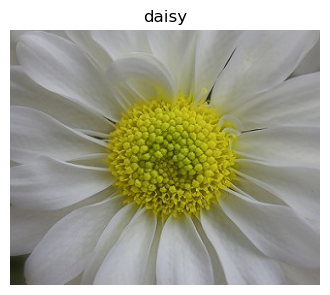

In [2]:
# Dataset scan: collect image paths and labels
from pathlib import Path

DATA_DIR = Path('flowers')  # relative to notebook
classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
print('Classes found:', classes)

filepaths = []
labels = []
for cls in classes:
    cls_dir = DATA_DIR / cls
    for img_path in cls_dir.glob('*'):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
            filepaths.append(str(img_path))
            labels.append(cls)

print('Total images found:', len(filepaths))

# show a few examples
for i in range(min(5, len(filepaths))):
    print(i, labels[i], filepaths[i])

# Load and display the first example
if filepaths:
    img = matplotlib.image.imread(filepaths[0])
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(labels[0])
    plt.axis('off')
else:
    print('No images found in', DATA_DIR)

Keypoints found: 324
Descriptor shape: (324, 128)


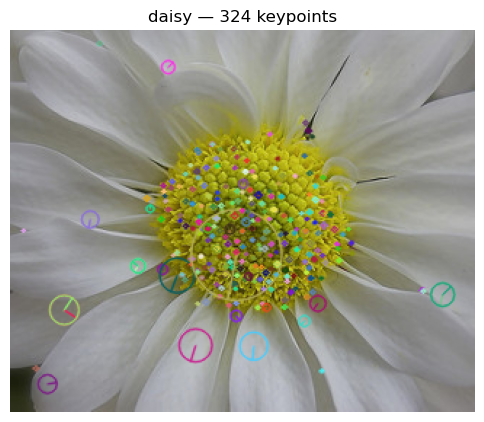

In [3]:
# Example: compute SIFT keypoints and descriptors for the first image
import cv2

if not filepaths:
    print('No images to process')
else:
    img_path = filepaths[0]
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print('cv2 failed to read', img_path)
    else:
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        # create SIFT
        if hasattr(cv2, 'SIFT_create'):
            sift = cv2.SIFT_create()
        else:
            sift = cv2.xfeatures2d.SIFT_create()

        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        print('Keypoints found:', len(keypoints))
        if descriptors is not None:
            print('Descriptor shape:', descriptors.shape)

        # visualize keypoints using matplotlib (convert BGR->RGB)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_kp = cv2.drawKeypoints(img_rgb, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(6,6))
        plt.imshow(img_kp)
        plt.title(f'{labels[0]} — {len(keypoints)} keypoints')
        plt.axis('off')

In [4]:
# Extract SIFT descriptors for all images (store per-image)
all_descriptors = []  # list of numpy arrays (n_keypoints x 128) per image
image_labels = []
image_paths = []

if not filepaths:
    print('No images found; skipping batch extraction')
else:
    # create SIFT if not already
    if hasattr(cv2, 'SIFT_create'):
        sift = cv2.SIFT_create()
    else:
        sift = cv2.xfeatures2d.SIFT_create()

    for path, lbl in zip(filepaths, labels):
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            print('Failed to read', path)
            continue
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        kps, desc = sift.detectAndCompute(img_gray, None)
        if desc is None:
            # no keypoints found — store empty array
            desc = np.empty((0, 128), dtype=np.float32)
        all_descriptors.append(desc)
        image_labels.append(lbl)
        image_paths.append(path)

    print('Extracted descriptors for', len(all_descriptors), 'images')
    # quick stats
    num_desc = sum(d.shape[0] for d in all_descriptors)
    print('Total descriptors:', num_desc)
    nonzero = sum(1 for d in all_descriptors if d.shape[0] > 0)
    print('Images with >=1 descriptor:', nonzero, '/', len(all_descriptors))

Extracted descriptors for 4317 images
Total descriptors: 2547468
Images with >=1 descriptor: 4317 / 4317


In [5]:
# Stratified train/test split (image-level)
from collections import Counter

if not image_paths:
    print('No images processed; cannot split')
else:
    X = image_paths
    y = image_labels
    # stratify by label to preserve balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print('Train size:', len(X_train))
    print('Test size:', len(X_test))
    print('Train class distribution:', Counter(y_train))
    print('Test class distribution:', Counter(y_test))

    # Save split indices (optional)
    split = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


Train size: 3453
Test size: 864
Train class distribution: Counter({'dandelion': 842, 'tulip': 787, 'rose': 627, 'daisy': 611, 'sunflower': 586})
Test class distribution: Counter({'dandelion': 210, 'tulip': 197, 'rose': 157, 'daisy': 153, 'sunflower': 147})


In [ ]:
# BoVW / KNN scaffold (do not run heavy ops automatically)
# This cell outlines the next steps and provides code to run k-means and train KNN when ready.

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Parameters (tune these)
VOCAB_SIZE = 200  # number of visual words (adjust based on dataset size)
RANDOM_STATE = 42

print('BoVW scaffold prepared. Next steps:')
print('1) Stack a random subset of descriptors from training images to fit k-means (vocab).')
print('2) Quantize each image''s descriptors to nearest visual words and build normalized histogram (length VOCAB_SIZE).')
print('3) Fit KNN on training histograms and evaluate on test histograms.')

# Example pseudocode as comments:
#
# # Build codebook
# sampled_desc = np.vstack(random_sample_of_descriptors_from_train)
# kmeans = MiniBatchKMeans(n_clusters=VOCAB_SIZE, random_state=RANDOM_STATE)
# kmeans.fit(sampled_desc)
#
# # Encode images
# def encode_image(descriptors, kmeans):
#     if descriptors.shape[0] == 0:
#         return np.zeros(VOCAB_SIZE)
#     words = kmeans.predict(descriptors)
#     hist, _ = np.histogram(words, bins=np.arange(VOCAB_SIZE+1))
#     hist = hist.astype(float)
#     hist = hist / (np.linalg.norm(hist) + 1e-6)  # L2 normalize
#     return hist
#
# X_train_hist = np.array([encode_image(desc_for_img, kmeans) for desc_for_img in train_descriptors])
# X_test_hist = np.array([encode_image(desc_for_img, kmeans) for desc_for_img in test_descriptors])
#
# # Train KNN
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_hist, y_train)
# y_pred = knn.predict(X_test_hist)
# print('Accuracy:', accuracy_score(y_test, y_pred))

print('\nWhen you want, run the next cell to build a vocabulary and train KNN. I can run it here if you confirm.')

BoVW scaffold prepared. Next steps:
1) Stack a random subset of descriptors from training images to fit k-means (vocab).
2) Quantize each images descriptors to nearest visual words and build normalized histogram (length VOCAB_SIZE).
3) Fit KNN on training histograms and evaluate on test histograms.

When you want, run the next cell to build a vocabulary and train KNN. I can run it here if you confirm.


In [7]:
# === BoVW (k-means) + KNN pipeline (runs k-means; may be slow on large descriptor sets) ===
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Configurable parameters
VOCAB_SIZE = 200
SAMPLE_DESC_MAX = 100000  # max descriptors to sample for k-means
KNN_NEIGHBORS = 5
SAVE_MODELS = True
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

# Check prerequisites
if not all_descriptors:
    raise RuntimeError('No descriptors available. Run the extraction cell first.')

# Prepare training descriptor pool
train_indices = [image_paths.index(p) for p in split['X_train']]
train_descs = [all_descriptors[i] for i in train_indices if all_descriptors[i].shape[0] > 0]
if not train_descs:
    raise RuntimeError('No descriptors found in training images; cannot build vocabulary.')

stacked = np.vstack(train_descs)
print('Total training descriptors available:', stacked.shape)

# Subsample descriptors if too many
rng = np.random.RandomState(RANDOM_STATE)
if stacked.shape[0] > SAMPLE_DESC_MAX:
    idxs = rng.choice(stacked.shape[0], size=SAMPLE_DESC_MAX, replace=False)
    sampled = stacked[idxs]
else:
    sampled = stacked
print('Descriptors used for k-means:', sampled.shape)

# Fit k-means
kmeans = MiniBatchKMeans(n_clusters=VOCAB_SIZE, random_state=RANDOM_STATE, batch_size=1000)
print('Fitting MiniBatchKMeans...')
kmeans.fit(sampled)
print('K-means fitted.')

# Encoder
def encode_image(desc, kmeans, vocab_size=VOCAB_SIZE):
    if desc is None or desc.shape[0] == 0:
        return np.zeros(vocab_size, dtype=float)
    words = kmeans.predict(desc)
    hist, _ = np.histogram(words, bins=np.arange(vocab_size+1))
    hist = hist.astype(float)
    # L2 normalize
    norm = np.linalg.norm(hist)
    if norm > 1e-6:
        hist /= norm
    return hist

# Encode train and test images
print('Encoding train images...')
X_train_hist = np.array([encode_image(all_descriptors[image_paths.index(p)], kmeans) for p in split['X_train']])
print('Encoding test images...')
X_test_hist  = np.array([encode_image(all_descriptors[image_paths.index(p)], kmeans) for p in split['X_test']])

# Train KNN
print('Training KNN...')
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)
knn.fit(X_train_hist, split['y_train'])
print('KNN trained.')

# Predict
y_pred = knn.predict(X_test_hist)
print('Accuracy:', accuracy_score(split['y_test'], y_pred))
print('\nClassification report:\n', classification_report(split['y_test'], y_pred))

# Confusion matrix
cm = confusion_matrix(split['y_test'], y_pred, labels=classes)
print('Confusion matrix (rows=true, cols=pred):')
print(cm)

# Save models
if SAVE_MODELS:
    joblib.dump(kmeans, MODEL_DIR / 'kmeans_bovw.joblib')
    joblib.dump(knn, MODEL_DIR / 'knn_bovw.joblib')
    print('Saved kmeans and knn to', MODEL_DIR)

Total training descriptors available: (2054698, 128)
Descriptors used for k-means: (100000, 128)
Fitting MiniBatchKMeans...
K-means fitted.
Encoding train images...
K-means fitted.
Encoding train images...
Encoding test images...
Encoding test images...
Training KNN...
KNN trained.
Accuracy: 0.4861111111111111

Classification report:
               precision    recall  f1-score   support

       daisy       0.41      0.44      0.43       153
   dandelion       0.59      0.51      0.55       210
        rose       0.42      0.41      0.41       157
   sunflower       0.50      0.67      0.57       147
       tulip       0.49      0.42      0.45       197

    accuracy                           0.49       864
   macro avg       0.48      0.49      0.48       864
weighted avg       0.49      0.49      0.48       864

Confusion matrix (rows=true, cols=pred):
[[ 67  25  18  28  15]
 [ 34 108  16  26  26]
 [ 16  20  64  23  34]
 [ 19  11   7  98  12]
 [ 26  18  48  22  83]]
Saved kmeans and 